In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# You have to run this block first time
# However, don't need to run twice
#
# from keras.applications.vgg16 import VGG16
# tf.reset_default_graph()

# # vgg = VGG16(weights='imagenet',
# #             include_top=False,
# #             input_shape=(150, 150, 3))
# model = VGG16(weights='imagenet')

In [3]:
# You have to run this block first time
# However, don't need to run twice
#
# model.save('save/vgg.h5')

In [4]:
import tensorflow as tf
from keras.models import load_model
tf.reset_default_graph()
model = load_model('save/vgg.h5')
x = model.input
print(x.shape)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



Using TensorFlow backend.


(?, 224, 224, 3)


/Users/sungchullee/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [5]:
# g = tf.get_default_graph()
# for op in g.get_operations():
#     print(op.name)

In [6]:
g = tf.get_default_graph()

softmax = g.get_tensor_by_name('predictions/Softmax:0')
print(softmax.shape)
softmax_386_loss = tf.reduce_mean(softmax[:, 386]) #, axis=(0))
print(softmax_386_loss.shape)
block5_conv3 = g.get_tensor_by_name('block5_conv3/Relu:0')
print(block5_conv3.shape)

grads = tf.gradients(softmax_386_loss, block5_conv3)[0]
print(grads.shape)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
print(pooled_grads.shape)

init = g.get_operation_by_name('init')

(?, 1000)
()
(?, 14, 14, 512)
(?, 14, 14, 512)
(512,)


In [7]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

# The local path to our target image
img_path = './downloads/creative_commons_elephant.jpg'

# `img` is a PIL image of size 224x224
img = image.load_img(img_path, target_size=(224, 224))

# `img` is a float32 Numpy array of shape (224, 224, 3)
img = image.img_to_array(img)

# We add a dimension to transform our array into a "batch"
# of size (1, 224, 224, 3)
img = np.expand_dims(img, axis=0)

# Finally we preprocess the batch
# (this does channel-wise color normalization)
img = preprocess_input(img)
print(img.shape)
print(img[0,:,:,0].min(), img[0,:,:,0].max())
print(img[0,:,:,1].min(), img[0,:,:,1].max())
print(img[0,:,:,2].min(), img[0,:,:,2].max())

(1, 224, 224, 3)
-103.939 143.061
-116.779 138.22101
-123.68 131.32


In [8]:
preds = model.predict(img)
print('Predicted:', decode_predictions(preds, top=3)[0])


Predicted: [('n02504458', 'African_elephant', 0.909421), ('n01871265', 'tusker', 0.086182885), ('n02504013', 'Indian_elephant', 0.0043545826)]


In [9]:
np.argmax(preds[0])

386

In [10]:
with tf.Session() as sess:
    model.load_weights('save/vgg.h5')
    
    feed_dict = {x: img}
    block5_conv3_run, pooled_grads_run = sess.run([block5_conv3, pooled_grads], feed_dict=feed_dict)

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the elephant class
for i in range(512):
    block5_conv3_run[:,:,:,i] *= pooled_grads_run[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(block5_conv3_run, axis=-1)[0]

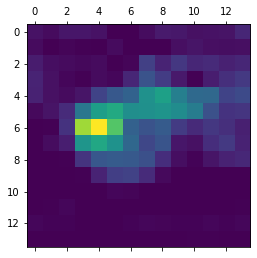

In [11]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [12]:
import cv2

# We use cv2 to load the original image
img_original = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img_original.shape[1], img_original.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img_original

# Save the image to disk
cv2.imwrite('./downloads/elephant_cam.jpg', superimposed_img)

True